<a href="https://colab.research.google.com/github/narendrapatel6321-dotcom/NLP-Assignments/blob/main/25N0242_NLP_Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. Importing Libraries and downloading resources

In [ ]:
# Import required libraries
import pandas as pd
import re
import kagglehub
import os
from bs4 import BeautifulSoup
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import numpy as np

In [ ]:
# Install gensim for Word2Vec
!pip install gensim
import gensim
from gensim.models import Word2Vec

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 24.7 MB/s eta 0:00:00


In [ ]:
#Download necessary NLTK resources
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

#2. Importing Dataset

Dataset Used : IMDB Dataset of 50K Movie Reviews

Link : https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews


In [ ]:
# Download IMDB dataset from Kaggle
path = kagglehub.dataset_download("lakshmi25npathi/imdb-dataset-of-50k-movie-reviews")
csv_file_path = os.path.join(path, 'IMDB Dataset.csv')

# Load CSV and subset to 15,000 rows for faster experimentation
df = pd.read_csv(csv_file_path).iloc[:15000].copy()

# Shuffle the dataset to randomize order for training/testing
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

Using Colab cache for faster access to the 'imdb-dataset-of-50k-movie-reviews' dataset.


# 3. Cleaning Data
 - Lowercasing
 - Removing HTML Tags
- Removing URLs
- Removing Punctuation & Special Characters
- Removing Extra Spaces

In [ ]:
# Function to clean raw text:
def remove_unwanted(text):

  url_pattern = r'https?://\S+|www\.\S+'
  punctuation_pattern = r"[^\w\s']"

  # Lowercase all text
  text = text.lower()

  # Remove HTML tags using BeautifulSoup
  text = BeautifulSoup(text, "html.parser").get_text()

  # Remove URLs using regex
  text = re.sub(url_pattern,'',text)

  # Remove punctuation
  text = re.sub(punctuation_pattern,'',text)

  # Normalize whitespace and strip leading/trailing spaces
  text = re.sub(r'\s+', ' ', text)
  text = text.strip()

  return text


In [ ]:
# Apply text cleaning function to all reviews
df["cleaned_review"] = df["review"].apply(remove_unwanted)
df[["review","cleaned_review"]].head()

,review,cleaned_review
0,Hundstage is an intentionally ugly and unnervi...,hundstage is an intentionally ugly and unnervi...
1,THE BRAIN THAT WOULDN'T DIE was considered so ...,the brain that wouldn't die was considered so ...
2,"As a European, the movie is a nice throwback t...",as a european the movie is a nice throwback to...
3,From the decrepit ranks of the already over-sa...,from the decrepit ranks of the already oversat...
4,Documentaries about fans are always mishmashes...,documentaries about fans are always mishmashes...


# Tokenising


#4. Removing stop_words and tokenization

In [ ]:
stop_words = set(stopwords.words("english"))

In [ ]:
# Function to tokenize text into words
def preprocess_tokens(text):
    tokens = word_tokenize(text)
    filtered_text = [ word for word in tokens
        if word.isalpha()          # keep only alphabetic tokens
        and 3 <= len(word) <= 20  # remove very short/long words
        and word not in stop_words # remove stopwords
                      ]
    return filtered_text

In [ ]:
# Apply preprocessing to all cleaned reviews
df["cleaned_tokens"] = df["cleaned_review"].apply(preprocess_tokens)
df[["cleaned_review","cleaned_tokens"]].head()

,cleaned_review,cleaned_tokens
0,hundstage is an intentionally ugly and unnervi...,"[hundstage, intentionally, ugly, unnerving, st..."
1,the brain that wouldn't die was considered so ...,"[brain, would, die, considered, distasteful, s..."
2,as a european the movie is a nice throwback to...,"[european, movie, nice, throwback, time, stude..."
3,from the decrepit ranks of the already oversat...,"[decrepit, ranks, already, oversaturated, horr..."
4,documentaries about fans are always mishmashes...,"[documentaries, fans, always, mishmashes, neve..."


#5. Stemming

In [ ]:
stemmer = PorterStemmer()
# Take a small subset of reviews
sample_df = df.sample(n=1000, random_state=42).reset_index(drop = True)

# Function to apply Porter stemming
def stem_words(text):
    stems = [stemmer.stem(word) for word in text]
    return stems

sample_df["stemmed_tokens"] = sample_df["cleaned_tokens"].apply(stem_words)
sample_df[["cleaned_tokens","stemmed_tokens"]].head()
# Done on a sample to save memory

,cleaned_tokens,stemmed_tokens
0,"[times, movie, seemed, get, whole, lot, compli...","[time, movi, seem, get, whole, lot, complic, n..."
1,"[best, shelley, duvall, highquality, faerie, t...","[best, shelley, duval, highqual, faeri, tale, ..."
2,"[flipping, channel, came, channel, urban, chan...","[flip, channel, came, channel, urban, channel,..."
3,"[young, girl, becomes, wartime, marine, penpal...","[young, girl, becom, wartim, marin, penpal, vi..."
4,"[film, decided, see, huge, fan, adult, animati...","[film, decid, see, huge, fan, adult, anim, qui..."


#6. Lemmatization

In [ ]:
lemmatizer = WordNetLemmatizer()

def lemmatize_word(tokens):
      lemmas = []
      for word in tokens:
        # First as verb
        lemma = lemmatizer.lemmatize(word, pos='v')
        # If unchanged, try as noun
        if lemma == word:
            lemma = lemmatizer.lemmatize(word, pos='n')

        lemmas.append(lemma)
      return lemmas


In [ ]:
# Lemmatize all tokens in the dataset
df["lemmatized_tokens"] = df["cleaned_tokens"].apply(lemmatize_word)
df[["cleaned_tokens","lemmatized_tokens"]].head()

,cleaned_tokens,lemmatized_tokens
0,"[hundstage, intentionally, ugly, unnerving, st...","[hundstage, intentionally, ugly, unnerve, stud..."
1,"[brain, would, die, considered, distasteful, s...","[brain, would, die, consider, distasteful, sev..."
2,"[european, movie, nice, throwback, time, stude...","[european, movie, nice, throwback, time, stude..."
3,"[decrepit, ranks, already, oversaturated, horr...","[decrepit, rank, already, oversaturated, horro..."
4,"[documentaries, fans, always, mishmashes, neve...","[documentary, fan, always, mishmash, never, wo..."


# 7. BoW

In [ ]:
# Convert lemmatized tokens back to full string for vectorizers
df["processed_text"] = df['lemmatized_tokens'].apply(lambda x : " ".join(x))
df[["lemmatized_tokens","processed_text"]].head()

,lemmatized_tokens,processed_text
0,"[hundstage, intentionally, ugly, unnerve, stud...",hundstage intentionally ugly unnerve study lif...
1,"[brain, would, die, consider, distasteful, sev...",brain would die consider distasteful several c...
2,"[european, movie, nice, throwback, time, stude...",european movie nice throwback time student exp...
3,"[decrepit, rank, already, oversaturated, horro...",decrepit rank already oversaturated horror sub...
4,"[documentary, fan, always, mishmash, never, wo...",documentary fan always mishmash never worth se...


In [ ]:
# convert column to list of strings
corpus = df['processed_text'].tolist()

# Create Bag-of-Words representation of the corpus
vectorizer = CountVectorizer()
# Fit on full dataset
X = vectorizer.fit_transform(corpus)

In [ ]:
# Convert only first 5 reviews to dense array for demonstration
X_array_demo = X[:5].toarray()
feature_names = vectorizer.get_feature_names_out()

print("Unique Word List: \n", feature_names)
print("Bag of Words Matrix (first 5 reviews): \n", X_array_demo)

Unique Word List: 
 ['aaa' 'aaaand' 'aaaarrgh' ... 'über' 'überwoman' 'ünfaithful']
Bag of Words Matrix (first 5 reviews): 
 [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


# 8. TF - IDF

In [ ]:
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(df['processed_text'])


In [ ]:
X_tfidf_demo = X_tfidf[:5].toarray()
feature_names = tfidf_vectorizer.get_feature_names_out()

print("Unique TF-IDF Feature Names: \n", feature_names)
print("TF-IDF Matrix (first 5 reviews): \n", X_tfidf_demo)

Unique TF-IDF Feature Names: 
 ['aaa' 'aaaand' 'aaaarrgh' ... 'über' 'überwoman' 'ünfaithful']
TF-IDF Matrix (first 5 reviews): 
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


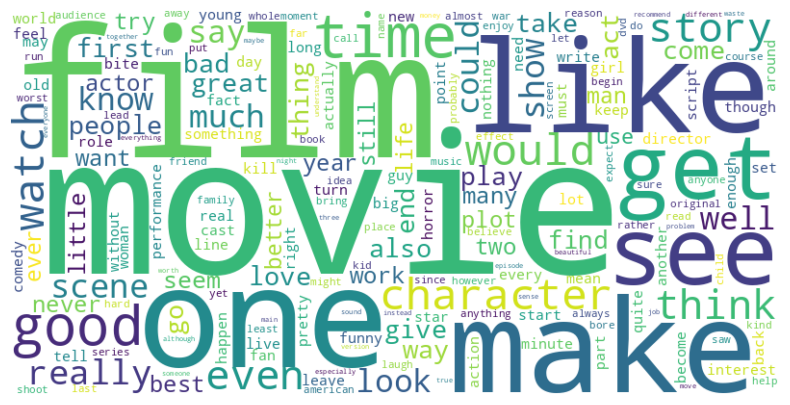

In [ ]:
word_freq = dict(zip(feature_names, X.toarray().sum(axis=0)))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

#9. One Hot Encoding

In [ ]:
# Flatten the list to get all words in the corpus
sample_df = df.sample(n=1000, random_state=42)
all_words = [word for tokens in sample_df['lemmatized_tokens'] for word in tokens]

# Get unique words (vocabulary)
vocab = sorted(set(all_words))

# Print vocabulary
print("Vocabulary:", vocab)

# Reshape the list of words into a 2D array for OneHotEncoder
word_array = np.array(all_words).reshape(-1, 1)

# Apply OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse_output=False)
one_hot_encoded = one_hot_encoder.fit_transform(word_array)

# Print the one-hot encoded data
print("One-hot encoded matrix:\n", one_hot_encoded)


Vocabulary: ['aage', 'aamir', 'aaron', 'abanazer', 'abandon', 'abbas', 'abbey', 'abbott', 'abbreviate', 'abc', 'abcthe', 'abdalla', 'abduct', 'abdulrahman', 'abhay', 'abide', 'abilitiesif', 'ability', 'abingdon', 'abishag', 'able', 'aboard', 'abominable', 'abomination', 'aboriginal', 'abortion', 'abound', 'abovementioned', 'abraham', 'abroad', 'abrupt', 'absence', 'absent', 'absolute', 'absolutely', 'absolutelyshame', 'absorb', 'absorbent', 'abstract', 'absurd', 'absurdist', 'absurdity', 'abundance', 'abundant', 'abundantly', 'abuse', 'abusive', 'abysmal', 'abyss', 'academic', 'academy', 'accent', 'accentuate', 'accept', 'acceptable', 'acceptance', 'access', 'accessible', 'accession', 'accident', 'accidental', 'accidentally', 'accidenti', 'accidently', 'accidentthat', 'acclaim', 'accommodate', 'accompany', 'accomplice', 'accomplish', 'accomplishment', 'accord', 'account', 'accountant', 'accumulation', 'accuracy', 'accurate', 'accurately', 'accusation', 'accuse', 'accustom', 'ace', 'ach

#10. Word2Vec



In [ ]:
sentences = df['lemmatized_tokens'].tolist()

In [ ]:
cbow_model = Word2Vec(sentences,
                      vector_size=100,
                      window=5, min_count=5,
                      sg=0, alpha=0.03,
                      min_alpha=0.0007, epochs=10)


In [ ]:
skipgram_model = Word2Vec(sentences,
                          vector_size=100,
                          window=5, min_count=5,
                          sg=1, alpha=0.03,
                          min_alpha=0.0007, epochs=10)


In [ ]:
word_1 = "good"
word_2 = "new"
try :
  word_vectors_cbow = cbow_model.wv
  similarity_cbow = word_vectors_cbow.similarity(word_1, word_2)
  print(f"Similarity between '{word_1}' and '{word_2}': {similarity_cbow} with CBOW")


  word_vectors_skipgram= skipgram_model.wv
  similarity_skip = word_vectors_skipgram.similarity(word_1, word_2)
  print(f"Similarity between '{word_1}' and '{word_2}': {similarity_skip} with Skip-Gram")
except KeyError:
  print("Either One Or Both words are not present in sentence")

Similarity between 'good' and 'new': 0.06773588806390762 with CBOW
Similarity between 'good' and 'new': 0.299714058637619 with Skip-Gram
